## Plotting
In this .ipynb file, the way of plotting the accessed data.
If the following code is executed, then the accessed data is plotted.

The code need to be executed after Py4J GatewayServer is started in the way of [Start Py4 GatewayServer](../sample-usage.ipynb#Start-Py4J-GatewayServer).

### Preparation

In [1]:
# Initializes Java gateway to use Java code from Python program.
from py4j.java_gateway import JavaGateway
gateway = JavaGateway()

In [2]:
data_store = gateway.jvm.signdoubt.gisutil.store.InMemorySortedStore(gateway.jvm.java.util.TreeMap())
index_store = gateway.jvm.signdoubt.gisutil.store.AccessLoggingSortedStore()

In [3]:
# initialize handler of spatial query
config = gateway.jvm.signdoubt.gisutil.EasyConfig(
    gateway.jvm.scala.collection.immutable.Map.Map1('subspace.point.count.max', '4'))
query_handler = (gateway.jvm.signdoubt.gisutil.core.SpatialQueryHandlerFactory
                 .subSpaceAwareQueryHandler(data_store, index_store, config))

In [4]:
# define utilities
def point(x, y):
    return gateway.jvm.signdoubt.gisutil.RoundedPoint(r(x), r(y))

def rectangle(low_x, low_y, up_x, up_y):
    return gateway.jvm.signdoubt.gisutil.Rectangle(r(low_x), r(low_y), r(up_x), r(up_y))

def r(v):
    return int(v * 10000000)

def restore(rectangle):
    def f(v):
        return float(v) / 10000000
    return (f(rectangle.lowerX()), f(rectangle.lowerY()), f(rectangle.upperX()), f(rectangle.upperY()))

def restore_point(rounded_point):
    def f(v):
        return float(v) / 10000000
    return (f(rounded_point.x()), f(rounded_point.y()))

In [5]:
import itertools
import numpy as np

# define sample data
np.random.seed(0)
xs = [135 + i for i in np.random.randn(100)]
ys = [35 + i for i in np.random.randn(100)]

# put data
for x, y in zip(xs, ys):
    query_handler.put(point(x, y), 'dummy data')

In [6]:
# matplotlib for plotting point
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

### Plotting SubSpaces and inserted points

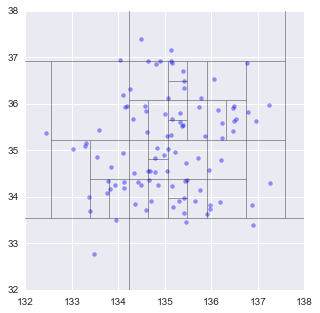

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(xs, ys, alpha=0.4, linewidths=0)

itr = index_store.toIterable().iterator()
while itr.hasNext():
    sub_space = itr.next()._2()
    lower_x, lower_y, upper_x, upper_y = restore(sub_space.rectangle())
    width = upper_x - lower_x
    height = upper_y - lower_y
    ax.add_patch(plt.Rectangle((lower_x, lower_y), width, height, linewidth=1, fill=False, alpha=0.2))

### Plotting SubSpaces when range scan is executed

In [8]:
# define utilities
def plot_base():
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.scatter(xs, ys, alpha=0.4, linewidths=0)
    return fig, ax

def plot_scan_area(ax, rect):
    index_store.logger().clear()
    query_handler.scan(rect)

    lower_x, lower_y, upper_x, upper_y = restore(rect)
    width = upper_x - lower_x
    height = upper_y - lower_y
    ax.add_patch(plt.Rectangle((lower_x, lower_y), width, height, linewidth=1, alpha=0.3))
    
def plot_accessed(ax):
    itr = index_store.logger().iterator()
    i = 0
    while itr.hasNext():
        i += 1
        sub_space = itr.next()._2().get()
        lower_x, lower_y, upper_x, upper_y = restore(sub_space.rectangle())
        width = upper_x - lower_x
        height = upper_y - lower_y
        ax.add_patch(plt.Rectangle((lower_x, lower_y), width, height, linewidth=1, fill=False, alpha=0.2))
        plt.text(lower_x, lower_y, '#' + str(i), alpha=0.7)

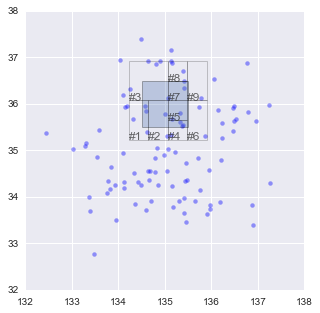

In [9]:
# plotting SubSpaces for range scan (1)
fig, ax = plot_base()
plot_scan_area(ax, rectangle(134.5, 35.5, 135.5, 36.5))
plot_accessed(ax)

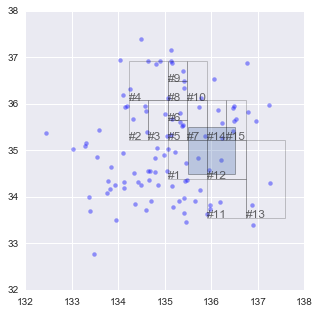

In [10]:
# plotting SubSpaces for range scan (2)
fig, ax = plot_base()
plot_scan_area(ax, rectangle(135.5, 34.5, 136.5, 35.5))
plot_accessed(ax)

### Plotting SubSpaces when nearest search is executed

In [11]:
# define utilities
def plot_nearest_search(ax, base_point, k):
    plt.scatter(base_point[0], base_point[1], c='black', marker='x', linewidths=2)
    index_store.logger().clear()

    # search k-nearest neighbors
    itr = query_handler.nearestNeighbor(point(base_point[0], base_point[1]), k).iterator()
    knn = []
    while (itr.hasNext()):
        knn.append(restore_point(itr.next()._1()))

    # plot k-nearest neighbors
    knn_x, knn_y = zip(*knn)
    plt.scatter(knn_x, knn_y, c='red', alpha=0.5, linewidths=0)

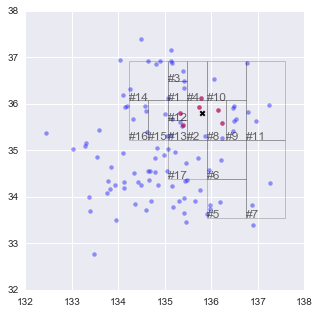

In [12]:
# plotting SubSpaces for k-nearest neighbors scan
k = 6
base_point = (135.8, 35.8)

fig, ax = plot_base()
plot_nearest_search(ax, base_point, k)
plot_accessed(ax)